# Efficient Frontier (Markowitz Portfolio Optimization)

Helpful Blog Posts:
* [Markowitz’s Efficient Frontier in Python [Part 1/2]](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314)
* [Markowitz’s Efficient Frontier in Python [Part 2/2]](https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94)
* [Investment Portfolio Optimization](http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html)

## Modern Portfolio Theory
Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title "Portfolio Selection" in the Journal of Finance in 1952.

Higher risk is associated with greater probability of higher return and lower risk with a greater probability of smaller return. MPT assumes that investors are risk-averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. Thus, an investor will take on increased risk only if compensated by higher expected returns.

Another factor comes in to play in MPT is "diversification". Modern portfolio theory says that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the portfolio.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [62]:
import pandas_datareader.data as web
stock = ["AAPL", "AMZN", "FB", "GOOG", "MSFT", "NFLX"]
data = web.DataReader(stock,data_source="yahoo",start='29/11/2017')['Adj Close']

In [63]:
data.head()

Symbols,AAPL,AMZN,FB,GOOG,MSFT,NFLX
Date,,,,,,
2017-11-28,167.986099,1193.599976,182.419998,1047.410034,82.219917,199.179993
2017-11-29,164.501587,1161.270020,175.130005,1021.659973,80.728165,188.149994
2017-11-30,166.801956,1176.750000,177.179993,1021.409973,81.532158,187.580002
2017-12-01,166.025436,1162.349976,175.100006,1010.169983,81.619354,186.820007
2017-12-04,164.812134,1133.949951,171.470001,998.679993,78.539001,184.039993


In [64]:
# Plotly graph
'''import plotly.graph_objects as go
fig = go.Figure()
idx = 0
for i in data.columns:
    fig.add_trace(go.Scatter(x=data.index, y=data[stock[idx]], name=stock[idx]))
    idx += 1
fig.update_layout(yaxis_title="Price in $")
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure()\nidx = 0\nfor i in data.columns:\n    fig.add_trace(go.Scatter(x=data.index, y=data[stock[idx]], name=stock[idx]))\n    idx += 1\nfig.update_layout(yaxis_title="Price in $")\nfig.show()'

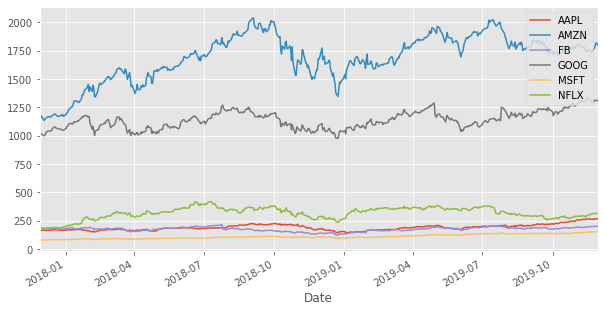

In [65]:
data.plot(figsize=(10,5))
plt.legend(loc="upper right")
plt.show()

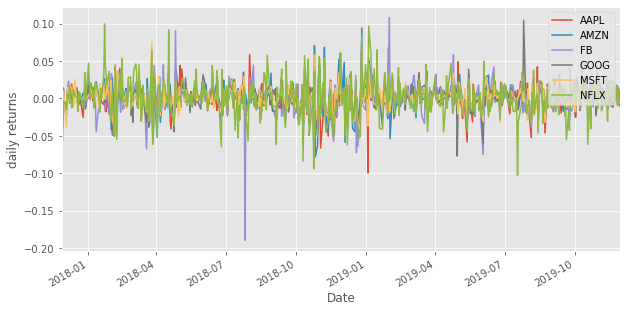

In [66]:
returns = data.pct_change()
returns.plot(figsize=(10,5))
plt.ylabel("daily returns")
plt.legend(loc="upper right")
plt.show()

## Random Portfolios Generation
We have 6 stocks in our portfolio. The decision we have to take is how should we allocate the budget to each of the stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock.

``portfolio_annualized_performance`` function will calculate the returns and volatility, and to make it as an annualized calculation (I take into account 252 as the number of trading days in one year), ``random_portfolios`` function will generate portfolios with random weights assigned to each stock, and by passing ``num_portfolio`` argument, you can decide how many random portfolios you want to generate.

In [67]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

In [68]:
def random_portfolios(num_portfolio, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolio))
    weights_record = []
    for i in range(num_portfolio):
        weights = np.random.random(len(stock))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return-risk_free_rate)/portfolio_std_dev
    return results, weights_record

In [69]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolio = 10000
risk_free_rate = 0.0178

The function given below generates random portfolio and provides the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weight for the corresponding result. It displays maximum Sharpe ratio portfolio with red star and minimum volatility portfolio with green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [70]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolio, risk_free_rate):
    results, weights = random_portfolios(num_portfolio, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=data.columns,columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100,2) for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    print("Maximum Sharpe Ratio Portfolio Allocation")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print(max_sharpe_allocation)
    print("\n")
    print("Minimum Volatility Portfolio Allocation")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized Volatility:", round(sdp_min,2))
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min,marker='*',color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized volatility')
    plt.ylabel('Annualized returns')
    plt.legend(labelspacing=0.8)

Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.29
Annualized Volatility: 0.23
Symbols      AAPL  AMZN    FB   GOOG   MSFT  NFLX
allocation  17.64  0.86  4.64  10.43  63.88  2.54


Minimum Volatility Portfolio Allocation
Annualized Return: 0.25
Annualized Volatility: 0.23
Symbols      AAPL  AMZN   FB   GOOG   MSFT  NFLX
allocation  25.28  0.87  8.5  23.53  38.19  3.63


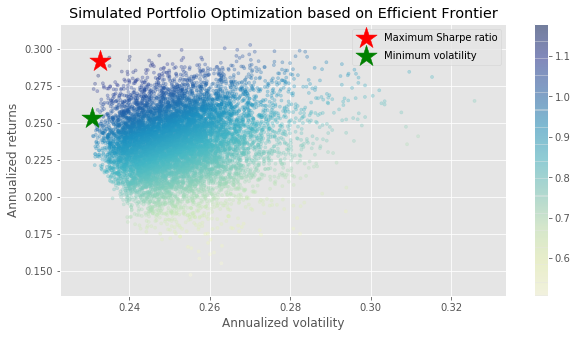

In [71]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolio, risk_free_rate)

For minimum risk portfolio, we can see that more than half of our budget is allocated to Microsoft and Google. For maximum risk portfolio, we can see that more than half of our budget is allocated to Microsoft and Apple.

# Efficient Frontier
From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called **efficient frontier**. It is named efficient frontier because the points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns.If the expected returns are the same, why would one take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

If you are an advanced Excel user, you might be familiar with 'solver' function in Excel. Scipy's optimize function is doing the similar task when given what to optimize, and what are constraints and bounds.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no ``maximize``, so you need to pass something that should be minimized as an objective function. That is why the first ``neg_sharpe_ratio`` computes the negative Sharpe ratio. Now we can use this as our objective function to minimize. In ``max_sharpe_ratio`` function, you first define arguments (this should not include the variables you would like to change for optimization, in this case, ``weights``). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated.

``constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})``

The above constraint is saying that sum of x should be equal to 1. You can think of the ``fun`` part construction as ``1`` on the right side of equal sign has been moved to the left side of the equal sign.

``'np.sum(x) == 1' has become 'np.sum(x)-1'``

It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

``bounds`` is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [72]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate)/p_var

import scipy.optimize as sco

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define the optimizing function for calculating minimum volatility portfolio. We want to minimize volatility by trying different weights. "Constraints" and "bounds" are same as the above.

In [73]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called **efficient frontier**. Below I define other functions to compute efficient frontier. The first function *efficient_return* is calculating the most efficient portfolio for a given target return, and the second function *efficient_frontier* will take a range of target returns and compute efficient portfolio for each return level.

In [74]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility alonf with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's ``minimize`` function. And the below function will also plot the efficient frontier line.

In [75]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe['x'], index=data.columns, columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100, 2)for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    print("Maximum Sharpe Ratio Portfolio Allocation")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print(max_sharpe_allocation)
    print("\n")
    print("Minimum Volatility Portfolio Allocation")
    print("Annualized Return:", round(rp_min, 2))
    print("Annualized Volatility:", round(sdp_min, 2))
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(results[0,:], results[1,:], c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([pf['fun'] for pf in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized volatility')
    plt.ylabel('Annualized returns')
    plt.legend(labelspacing=0.8)

Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.33
Annualized Volatility: 0.24
Symbols     AAPL  AMZN   FB  GOOG   MSFT  NFLX
allocation  7.95   0.0  0.0   0.0  92.05   0.0


Minimum Volatility Portfolio Allocation
Annualized Return: 0.26
Annualized Volatility: 0.23
Symbols     AAPL  AMZN    FB   GOOG   MSFT  NFLX
allocation  25.2   0.0  9.28  22.04  43.48   0.0


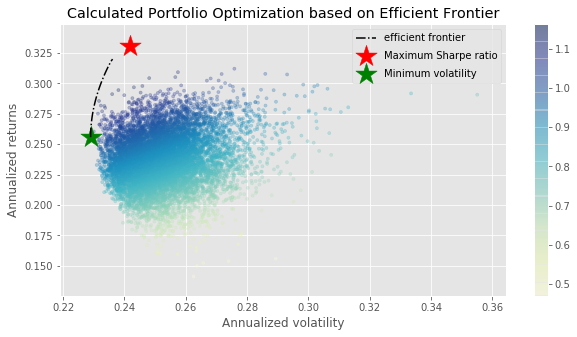

In [76]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolio, risk_free_rate)

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [77]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe['x'], index=data.columns, columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100, 2)for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns)*np.sqrt(252)
    an_rt = mean_returns*252

    print("Maximum Sharpe Ratio Portfolio Allocation")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print(max_sharpe_allocation)
    print("\n")
    print("Minimum Volatility Portfolio Allocation")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized Volatility:", round(sdp_min,2))
    print(min_vol_allocation)
    print("Individual Stock Returns and Volatility")
    for i, txt in enumerate(data.columns):
        print(txt,":","Annualized Return", round(an_rt[i],2),", Annualized Volatility:", round(an_vol[i], 2))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(an_vol,an_rt, marker='o', s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([pf['fun'] for pf in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualized volatility')
    ax.set_ylabel('annualized returns')
    ax.legend(labelspacing=0.8)

Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.33
Annualized Volatility: 0.24
Symbols     AAPL  AMZN   FB  GOOG   MSFT  NFLX
allocation  7.95   0.0  0.0   0.0  92.05   0.0


Minimum Volatility Portfolio Allocation
Annualized Return: 0.26
Annualized Volatility: 0.23
Symbols     AAPL  AMZN    FB   GOOG   MSFT  NFLX
allocation  25.2   0.0  9.28  22.04  43.48   0.0
Individual Stock Returns and Volatility
AAPL : Annualized Return 0.27 , Annualized Volatility: 0.27
AMZN : Annualized Return 0.25 , Annualized Volatility: 0.3
FB : Annualized Return 0.11 , Annualized Volatility: 0.33
GOOG : Annualized Return 0.14 , Annualized Volatility: 0.26
MSFT : Annualized Return 0.34 , Annualized Volatility: 0.25
NFLX : Annualized Return 0.31 , Annualized Volatility: 0.41


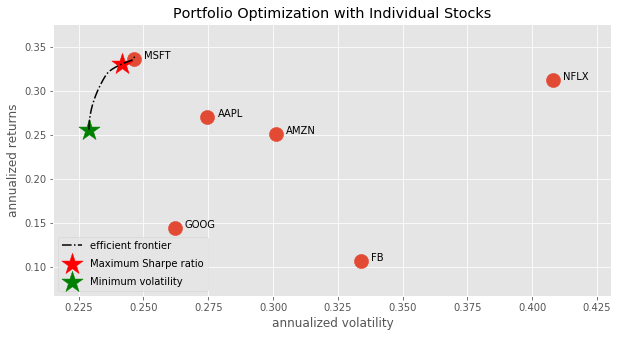

In [78]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is Google at around 0.26. But with portfolio optimisation, we can achieve even lower risk at 0.23, and still with a higher return than Google.

Considering how vast and deep the finance field is, I've probably only scratched the surface. But I had fun going through coding and trying to understand the concept.